## Import Libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [2]:
# Parameters
col_indx = 4  #! 3 is meta.bias, 4 is meta.rbias, -1 means use meta.fbias from colvar_reweight file
data_path = "../../../"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.colvars.dat"
out_dir ="./"

## Load MetaD Trajectory for ADP

In [3]:
backbone_selection_101 = "(name C and resid 1) or (name C CA N and resid 2) or (name N and resid 3)"

# load data
prmtopFileName =  data_path + gro_file
trajFiles = [data_path+traj_file]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("selected atom indices:", sel_backbone_101.indices)

print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

['../../../run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr']
1
selected atom indices: [ 4  6  8 14 16]
Number of atoms in trajectory: 22
Number of frames in trajectory: 100001
Number of atoms being analyzed: 5
Number of frames being analyzed: 100001


## load phi-psi data and bias from metad sim

In [4]:
if col_indx != -1:
    time, phi, psi, bias = np.loadtxt(data_path+colvar_file, usecols=(0,1,2,col_indx), unpack=True)
else:
    # loads the final bias 
    time, phi, psi, bias = np.loadtxt(data_path+"colvar_reweight", usecols=(0,1,2,3), unpack=True)
    bias -= bias.min()

time *= 0.001  # in ns

## plot phi-psi

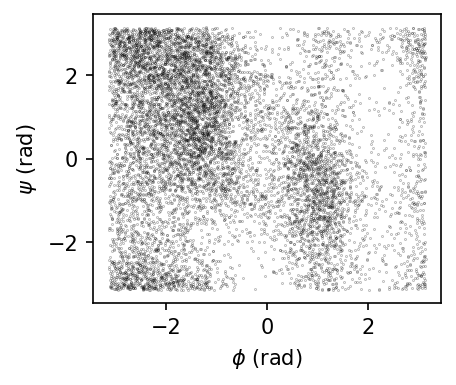

In [5]:
plt.figure(figsize=(3.0,2.5), dpi=150)
plt.xlabel("$\phi$ (rad)")
plt.ylabel("$\psi$ (rad)")
plt.scatter(phi[::10], psi[::10], marker=".", s=0.05, color='k', alpha=1.0)

## plot different choice of metad biases

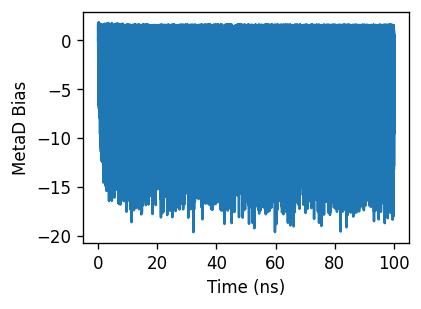

In [6]:
plt.figure(figsize=(3.5,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("MetaD Bias")
plt.plot(time, bias)

## plot different weights for reweighting

In [7]:
kbt = 0.596161 # in kcal/mol @ 300K

# calculate biases
weights = np.exp(bias/kbt)
weights /= np.sum(weights)

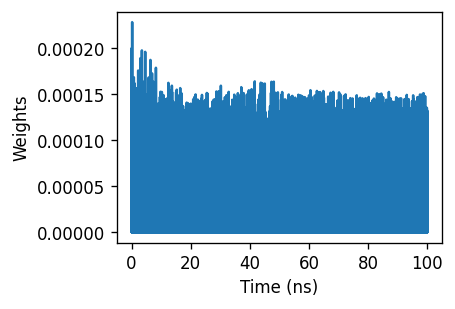

In [8]:
plt.figure(figsize=(3.5,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("Weights")
plt.plot(time, weights)

## n_clusters = 2 

In [9]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 2, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 2
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              53.691          81.780
       2              53.818          72.172
       3              53.887          76.173
       4              54.533          19.845
       5              47.961          76.555
       6              56.539          23.140
       7              53.858          74.811
       8              53.893          71.780
       9              57.129          50.573
      10              53.876          63.609
      11              53.384          75.866
      12              53.045          78.290
      13              53.872          73.790
      14              45.884          68.072
      15              53.900          75.890
      16              32.489          81.577
      17              53.833          74.970
      18              53.862          76.246
      19       

In [10]:
with open("wsgmm_2state_nattempts_40.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [11]:
with open("wsgmm_2state_nattempts_40.pickle", "rb") as f:
    wsgmm2 = pickle.load(f)

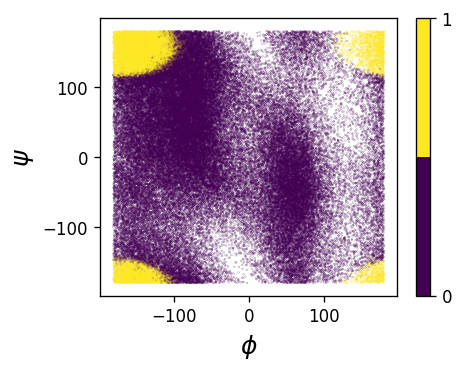

In [12]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm2.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm2.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 3 

In [13]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              54.885          37.689
       2              58.120          95.392
       3              58.152          22.708
       4              58.520          38.793
       5              58.098          89.573
       6              55.241         100.370
       7              57.875          96.693
       8              43.936          88.368
       9              58.082         103.856
      10              57.432          95.785
      11              54.912          35.372
      12              58.520          62.055
      13              58.153          35.290
      14              57.503         100.447
      15              54.880          80.254
      16              54.867          96.725
      17              57.529          75.701
      18              57.293          94.636
      19       

In [14]:
with open("wsgmm_3state_nattempts_40.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [15]:
with open("wsgmm_3state_nattempts_40.pickle", "rb") as f:
    wsgmm3 = pickle.load(f)

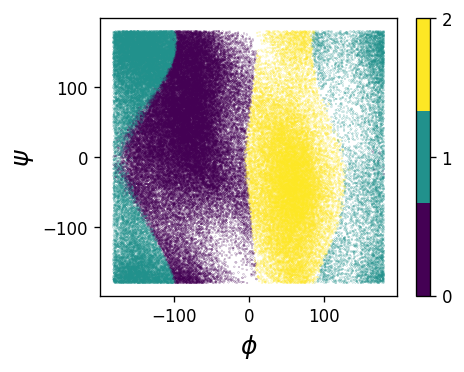

In [16]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm3.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm3.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

## n_clusters = 4 

In [17]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 4, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 4
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              54.848         100.944
       2              58.153          38.332
       3              58.704         121.252
       4              58.858          58.123
       5              54.868         100.735
       6              58.851          57.227
       7              57.888         106.993
       8              57.530          98.518
       9              57.487         106.436
      10              57.543         102.898
      11              58.700          47.496
      12              58.357          55.443
      13              58.146          24.160
      14              53.890          93.397
      15              58.896         128.394
      16              57.543         100.963
      17              53.037          19.432
      18              54.755         113.380
      19       

In [18]:
with open("wsgmm_4state_nattempts_40.pickle", "wb") as f:
    pickle.dump(wsgmm, f)

In [19]:
with open("wsgmm_4state_nattempts_40.pickle", "rb") as f:
    wsgmm4 = pickle.load(f)

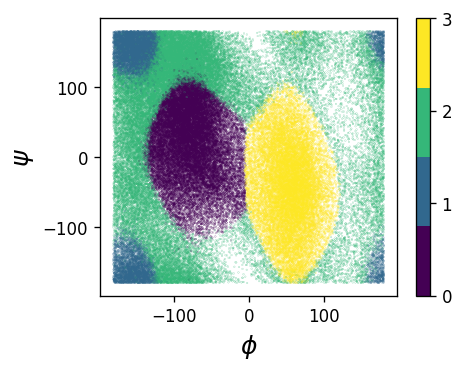

In [20]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm4.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm4.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)

## n_clusters = 5 -->

In [21]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 5, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 5
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              58.157          35.563
       2              53.239          23.663
       3              58.035         137.477
       4              59.211          45.197
       5              58.320         149.153
       6              54.545          12.187
       7              58.881          62.334
       8              58.066         119.789
       9              58.162          30.637
      10              58.371          86.720
      11              58.502          41.274
      12                 nan          15.411
      13              57.825         129.219
      14              57.564         120.134
      15              59.179          52.605
      16              57.543          96.466
      17              59.078         138.251
      18              59.194          60.455
      19       

In [22]:
with open("wsgmm_5state_nattempts_40.pickle", "wb") as f:
    pickle.dump(wsgmm, f)

In [23]:
with open("wsgmm_5state_nattempts_40.pickle", "rb") as f:
    wsgmm5 = pickle.load(f)

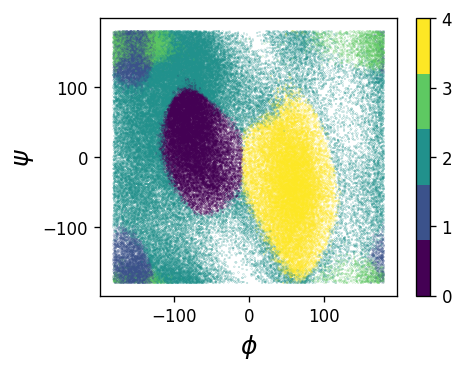

In [24]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm5.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)

## n_clusters = 6 -->

In [25]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 6, 40, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 6
Number of attempts: 40
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              58.351         142.639
       2              59.292          75.794
       3              57.545          48.716
       4              59.305          85.643
       5              58.871          34.108
       6              59.125          58.893
       7              59.207          39.966
       8              58.038         156.925
       9              58.877          47.207
      10              59.194          54.510
      11              59.498          60.815
      12              58.168          30.266
      13              59.070         155.245
      14              54.892          48.515
      15              59.308          58.676
      16              58.662          71.622
      17              58.679          58.989
      18              58.681         154.281
      19       

In [26]:
with open("wsgmm_6state_nattempts_40.pickle", "wb") as f:
    pickle.dump(wsgmm, f)

In [27]:
with open("wsgmm_6state_nattempts_40.pickle", "rb") as f:
    wsgmm6 = pickle.load(f)

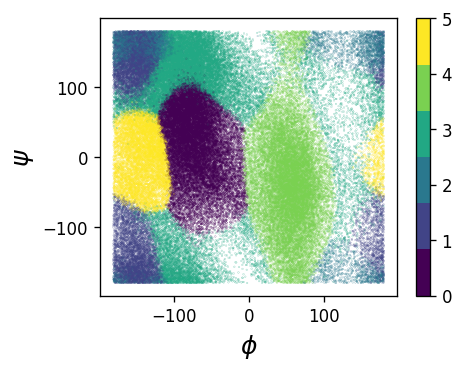

In [28]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm6.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


# plot
plt.figure(figsize=(4,3), dpi=120)
plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("$\psi$", fontsize=15)
plt.yticks([-100,0,100])
plt.scatter(phi*180/3.14, psi*180/3.14, c=wsgmm6.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar=plt.colorbar(ticks=color_values)